# Jupyter Example 5 for HERMES: Neutrinos

In [1]:
from pyhermes import *
from pyhermes.units import PeV, TeV, GeV, mbarn, kpc, pc, deg, rad

import astropy.units as u

import numpy as np
import healpy
import matplotlib.pyplot as plt

HEMRES has available two cross-section modules for $pp \rightarrow \nu$:
   * one built on top of cparamlib: Kamae et al. 2006
   * one based on Kelner-Aharonian parametrization

In [2]:
kamae06 = interactions.Kamae06Neutrino()
kelahar = interactions.KelnerAharonianNeutrino()

In [3]:
E_neutrino_range = np.logspace(0,6,100)*GeV
E_proton_list = [10*GeV, 100*GeV, 1*TeV, 100*TeV, 1*PeV]

diff_sigma = lambda model, E_proton: [
    E_neutrino*model.getDiffCrossSection(E_proton, E_neutrino)/mbarn
    for E_neutrino in E_neutrino_range
]
diff_sigma_kamae06 = lambda E_proton: diff_sigma(kamae06, E_proton)
diff_sigma_kelahar = lambda E_proton: diff_sigma(kelahar, E_proton)

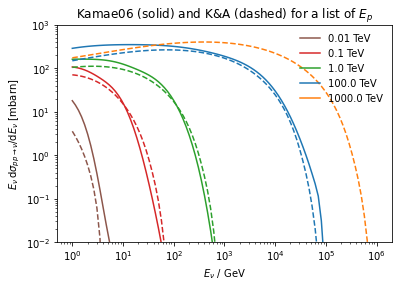

In [4]:
colors = ['tab:brown', 'tab:red', 'tab:green', 'tab:blue', 'tab:orange']
for E_proton, c in zip(E_proton_list, colors):
    plt.loglog(E_neutrino_range/GeV, diff_sigma_kamae06(E_proton),
               ls='-', color=c, label="{}".format(E_proton.toAstroPy().to('TeV').round(2)))
    plt.loglog(E_neutrino_range/GeV, diff_sigma_kelahar(E_proton),
               ls='--', color=c)
plt.ylim(top=1e3, bottom=1e-2)
plt.title("Kamae06 (solid) and K&A (dashed) for a list of $E_p$")
plt.xlabel(r"$E_\nu$ / GeV")
plt.ylabel(r"$E_\nu\, \mathrm{d}\sigma_{pp \rightarrow \nu} / \mathrm{d} E_\nu$ [mbarn]")
_ = plt.legend(loc="upper right", frameon=False)

In [5]:
def integrate_template(integrator, nside):
    
    integrator.setupCacheTable(60, 60, 12)
    sun_pos = Vector3QLength(8.0*kpc, 0*pc, 0*pc)
    integrator.setSunPosition(sun_pos)
    
    mask_edges = ([5*deg, 0*deg], [-5*deg, 180*deg])
    mask = RectangularWindow(*mask_edges)
    
    skymap_range = GammaSkymapRange(nside, 0.05*TeV, 1e4*TeV, 20)
    skymap_range.setIntegrator(integrator)
    skymap_range.setMask(mask)
    
    skymap_range.compute()
    
    return skymap_range

def integrate_neutrino(cosmicrays, gas, crosssection):
    nside = 256
    integrator = PiZeroIntegrator(cosmicrays, gas, crosssection)
    return integrate_template(integrator, nside)

In [6]:
neutral_gas_HI = neutralgas.RingModel(neutralgas.RingType.HI)
proton = cosmicrays.Dragon2D(Proton)

In [7]:
skymap_range_neutrino_HI_kamae06 = integrate_neutrino(proton, neutral_gas_HI, kamae06)
skymap_range_neutrino_HI_kelahar = integrate_neutrino(proton, neutral_gas_HI, kelahar)

In [8]:
#use_units = skymap_range_HI[0].getUnits() # default units for GammaSkymap (GeV^-1 m^-2 s^-1 sr^-1)
use_units = "GeV^-1 cm^-2 s^-1 sr^-1" # override default
skymap_units = u.Quantity(1, use_units)
base_units = skymap_units.unit.si.scale

In [9]:
def calc_mean_flux(skymap_range):
    energies = np.array([float(s.getEnergy()/GeV) for s in skymap_range])
    fluxes = np.array([s.getMean() for s in skymap_range]) / base_units
    return energies, fluxes

(100, 1000000)

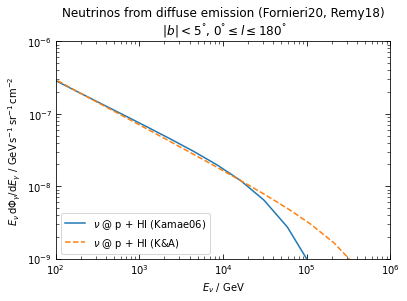

In [10]:
def plot_spectrum(skymap_range, label, style):
    energies, fluxes = calc_mean_flux(skymap_range)
    plt.plot(energies, fluxes*energies**2, style, label=label)
    
def plot_total_spectrum(list_of_skymap_range, label, style):
    fluxes = QDifferentialIntensity(0)
    for skymap_range in list_of_skymap_range:
        energies, fluxes_i = calc_mean_flux(skymap_range)
        fluxes = fluxes + fluxes_i
    plt.plot(energies, fluxes*energies**2, style, label=label)

fig, ax = plt.subplots()

plot_spectrum(skymap_range_neutrino_HI_kamae06, r'$\nu $ @ p + HI (Kamae06)', '-')
plot_spectrum(skymap_range_neutrino_HI_kelahar, r'$\nu $ @ p + HI (K&A)', '--')

plt.title("Neutrinos from diffuse emission (Fornieri20, Remy18)\n $|b| < 5^\degree$, $0^\degree \leq l \leq 180^\degree$")
plt.legend(loc="lower left")

plt.xlabel(r"$E_\nu$ / GeV")
plt.ylabel(r"$E_\nu\, \mathrm{d}\Phi_\gamma / \mathrm{d} E_\gamma$ / " + (skymap_units*u.GeV**2).unit.to_string(format='latex_inline'))

ax.tick_params(which='minor', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=3)
ax.tick_params(which='major', direction='in', axis='both', bottom=True, top=True, left=True, right=True, length=5)
plt.xscale("log")
plt.yscale("log")

plt.ylim(10**(-9), 10**(-6))
plt.xlim(10**(2), 10**(6))

#plt.savefig("img/neutrinos-from-diffuse-emission-spectrum-180.pdf", dpi=150)